In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import librosa.display
import IPython.display as ipd

In [5]:
# first, before we do anything, let's look/listen at some data.
# understand what we are interested in

data_path = Path("gamelan_music_dataset")
targets_first = data_path / "first ensemble/orchestra/target"

### harmonic percussive source separation of gamelan instruments
- you might want to have a look at this (https://librosa.org/librosa_gallery/auto_examples/plot_hprss.html)
- note that librosa is already applying wiener masking
- consider tweaking margin and kernel parameters of *librosa.decompose.hpss()*


/tmp/ipykernel_196368/3317894156.py:15: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D, ref=rp), y_axis="log")
/tmp/ipykernel_196368/3317894156.py:20: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D_harmonic, ref=rp), y_axis="log")
/tmp/ipykernel_196368/3317894156.py:25: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D_percussive, ref=rp), y_axis="log", x_axis="time")


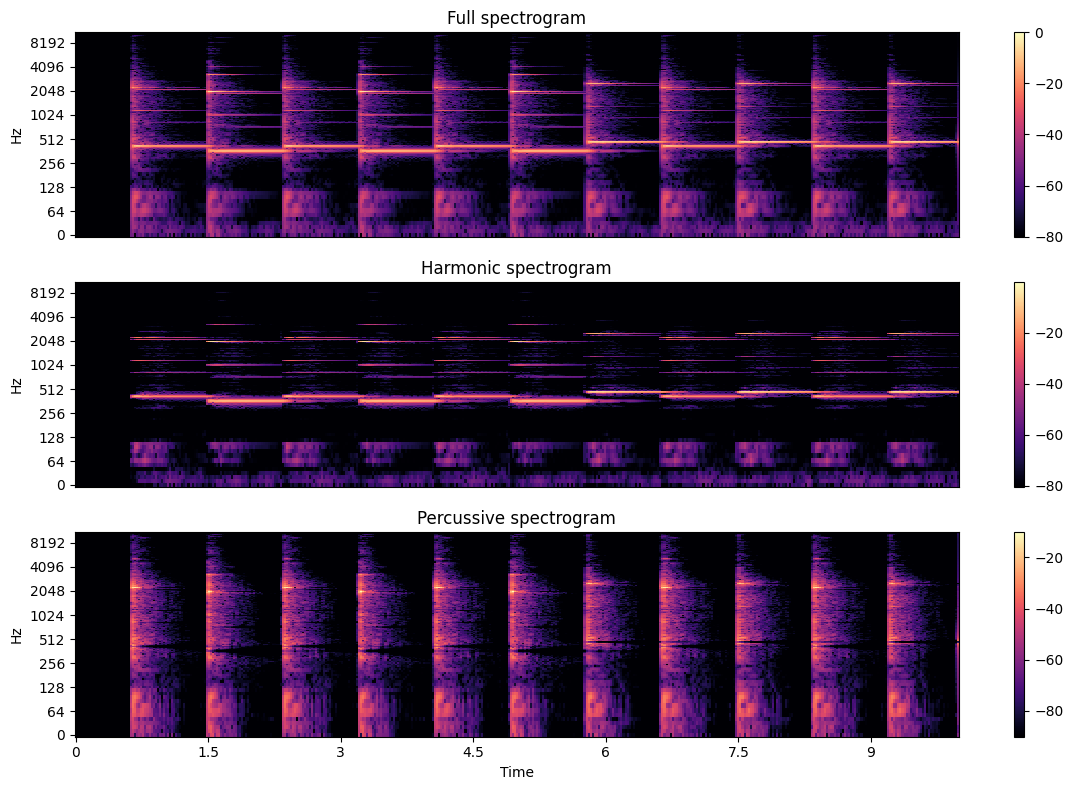

In [13]:
audio_file_path = targets_first / "demung/001.wav"

y, sr = librosa.load(audio_file_path,duration=10)

D = librosa.stft(y)
D_harmonic, D_percussive = librosa.decompose.hpss(D)

# Pre-compute a global reference power from the input spectrum
rp = np.max(np.abs(D))

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=rp), y_axis="log")
plt.colorbar()
plt.title("Full spectrogram")

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(D_harmonic, ref=rp), y_axis="log")
plt.colorbar()
plt.title("Harmonic spectrogram")

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(D_percussive, ref=rp), y_axis="log", x_axis="time")
plt.colorbar()
plt.title("Percussive spectrogram")
plt.tight_layout()

# playing the audio form the start and ending at 10 seconds, to match spectrogram
ipd.Audio(y[:sr*10], rate=sr)